<a href="https://colab.research.google.com/github/Khyati-55/Khyati-/blob/main/E22CSEU1709_TIME_SERIES_PROJECT_FINAL_EVALUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy matplotlib statsmodels scikit-learn xgboost tensorflow


In [ ]:
import sys
sys.setrecursionlimit(10000)


#0. IMPORTS & SETTINGS


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. DATA LOADING & CLEANING

In [ ]:
df = pd.read_csv('/content/india_traffic_2014_2024_with_states.csv', parse_dates=['datetime'])


df['state'].fillna('Delhi', inplace=True)


df = df.set_index('datetime').sort_index().asfreq('H')


df['traffic_volume'] = df['traffic_volume'].interpolate()
df['temperature_C'] = df['temperature_C'].interpolate()

df['rainfall_mm'] = df['rainfall_mm'].fillna(0)


print("Missing values after cleaning:\n", df.isna().sum())

print(df.head(), "\n")

Missing values after cleaning:
 traffic_volume    0
temperature_C     0
rainfall_mm       0
state             0
dtype: int64
                     traffic_volume  temperature_C  rainfall_mm      state
datetime                                                                  
2014-01-01 00:00:00            2024           13.0          4.0       Pune
2014-01-01 01:00:00            2209           14.2          6.0    Kolkata
2014-01-01 02:00:00            2190           16.8          2.0  Ahmedabad
2014-01-01 03:00:00            2491           18.7          2.0    Chennai
2014-01-01 04:00:00            2555           18.8          3.0       Pune 



#2. EXPLORATORY DATA ANALYSIS (EDA)

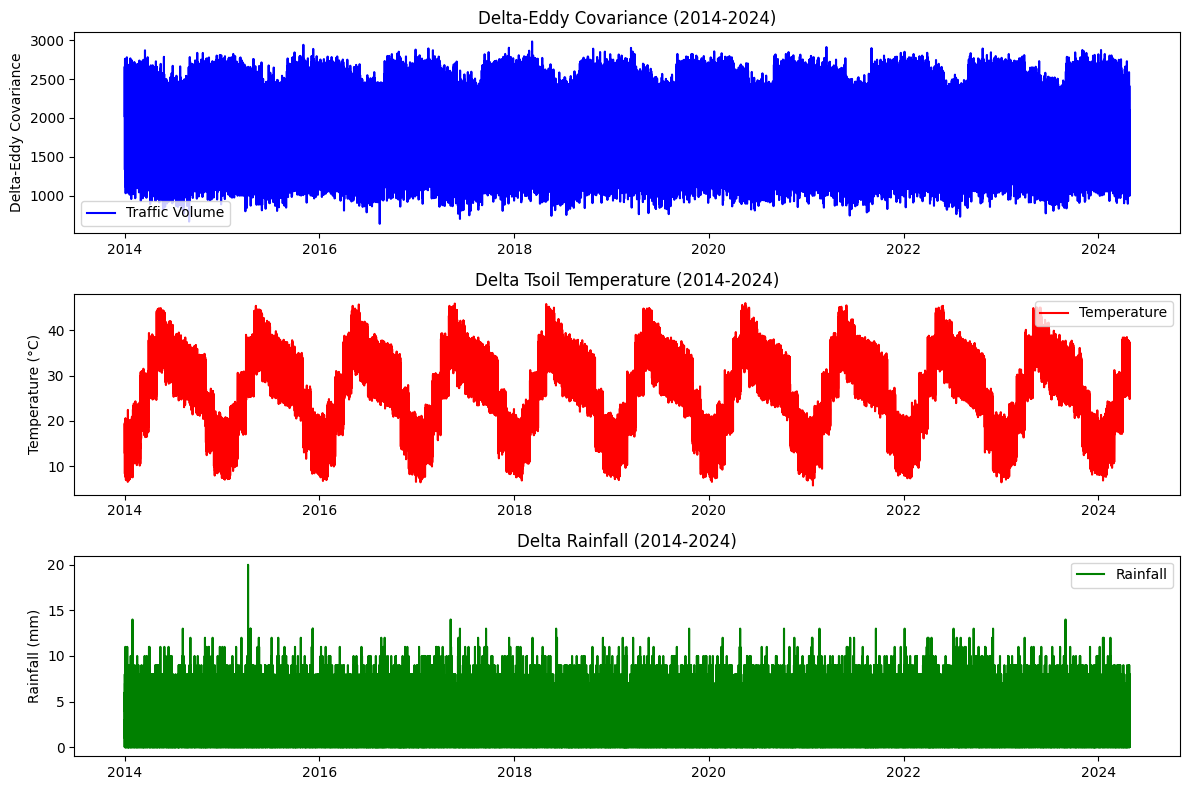

In [ ]:

fig, axs = plt.subplots(3, 1, figsize=(12, 8))

axs[0].plot(df['traffic_volume'], color='b', label="Traffic Volume")
axs[0].set_title("Delta-Eddy Covariance (2014-2024)")
axs[0].set_ylabel("Delta-Eddy Covariance")
axs[0].legend()

axs[1].plot(df['temperature_C'], color='r', label="Temperature")
axs[1].set_title("Delta Tsoil Temperature (2014-2024)")
axs[1].set_ylabel("Temperature (°C)")
axs[1].legend()

axs[2].plot(df['rainfall_mm'], color='g', label="Rainfall")
axs[2].set_title("Delta Rainfall (2014-2024)")
axs[2].set_ylabel("Rainfall (mm)")
axs[2].legend()

plt.tight_layout()
plt.show()


# 3. TRAIN / TEST SPLIT

In [ ]:

train = df.iloc[:-720]
test  = df.iloc[-720:]

print(f"Train size: {len(train)}, Test size: {len(test)}\n")

Train size: 89760, Test size: 720



# 4. MODEL FITTING & FORECASTING

In [ ]:

import numpy as np
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


predictions = {}


arima_sub = train['traffic_volume'][:5000]
arima_fast = ARIMA(arima_sub, order=(1,1,1)).fit()


fc = arima_fast.get_forecast(steps=len(test))
pred_arima = fc.predicted_mean

predictions['ARIMA-Fast'] = pd.Series(pred_arima.values, index=test.index)


hw = ExponentialSmoothing(
    train['traffic_volume'],
    seasonal_periods=168,
    trend='add',
    seasonal='add'
).fit(optimized=True)
pred_hw = hw.forecast(steps=len(test))
predictions['Holt-Winters'] = pd.Series(pred_hw, index=test.index)


scaler   = MinMaxScaler()
scaled   = scaler.fit_transform(train[['traffic_volume']])
window   = 24
Xl, yl   = [], []
for i in range(window, len(scaled)):
    Xl.append(scaled[i-window:i,0]); yl.append(scaled[i,0])
Xl = np.array(Xl).reshape(-1, window, 1)
yl = np.array(yl)

lstm = Sequential([LSTM(20, input_shape=(window,1)), Dense(1)])
lstm.compile('adam','mse')
lstm.fit(Xl, yl, epochs=2, batch_size=64, verbose=0)

last_seq  = scaled[-window:]
pred_lstm = []
for _ in range(len(test)):
    p = lstm.predict(last_seq.reshape(1,window,1), verbose=0)[0,0]
    pred_lstm.append(p)
    last_seq = np.vstack([last_seq[1:], [[p]]])
predictions['LSTM-Fast'] = pd.Series(
    scaler.inverse_transform(np.array(pred_lstm).reshape(-1,1)).flatten(),
    index=test.index
)


def create_lagged(arr, lags=24):
    X, y = [], []
    for i in range(lags, len(arr)):
        X.append(arr[i-lags:i]); y.append(arr[i])
    return np.array(X), np.array(y)

Xtr, ytr    = create_lagged(train['traffic_volume'].values, window)
full_vals   = np.concatenate([train['traffic_volume'], test['traffic_volume']])
Xall, _     = create_lagged(full_vals, window)
Xte         = Xall[-len(test):]

xgbr = xgb.XGBRegressor(objective='reg:squarederror',
                        tree_method='gpu_hist', n_jobs=-1)
pred_xgb = xgbr.fit(Xtr, ytr).predict(Xte)
predictions['XGBoost-GPU'] = pd.Series(pred_xgb, index=test.index)


ar_preds = predictions['ARIMA-Fast']


resids = train['traffic_volume'][:5000] - arima_fast.fittedvalues
res_scaled = scaler.fit_transform(resids.values.reshape(-1,1))


X_r, y_r = [], []
for i in range(window, len(res_scaled)):
    X_r.append(res_scaled[i-window:i,0]); y_r.append(res_scaled[i,0])
X_r = np.array(X_r).reshape(-1, window, 1)
y_r = np.array(y_r)

res_lstm = Sequential([LSTM(10, input_shape=(window,1)), Dense(1)])
res_lstm.compile('adam','mse')
res_lstm.fit(X_r, y_r, epochs=2, batch_size=64, verbose=0)


last_res = res_scaled[-window:]
hyb = []
for ar in ar_preds:
    r = res_lstm.predict(last_res.reshape(1,window,1), verbose=0)[0,0]
    hyb.append(ar + scaler.inverse_transform([[r]])[0,0])
    last_res = np.vstack([last_res[1:], [[r]]])

predictions['Hybrid-ARIMA+LSTM'] = pd.Series(hyb, index=test.index)


print("Models implemented and predictions generated:")
for model_name in predictions.keys():
    print(f"- {model_name}")




/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Models implemented and predictions generated:
- ARIMA-Fast
- Holt-Winters
- LSTM-Fast
- XGBoost-GPU
- Hybrid-ARIMA+LSTM


In [ ]:
print("ARIMA-Fast head:\n", predictions['ARIMA-Fast'].head())
print("Hybrid-ARIMA+LSTM head:\n", predictions['Hybrid-ARIMA+LSTM'].head())


ARIMA-Fast head:
 datetime
2024-03-29 00:00:00    2125.288220
2024-03-29 01:00:00    2115.596470
2024-03-29 02:00:00    2108.207259
2024-03-29 03:00:00    2102.573556
2024-03-29 04:00:00    2098.278293
Freq: h, dtype: float64
Hybrid-ARIMA+LSTM head:
 datetime
2024-03-29 00:00:00    2118.317236
2024-03-29 01:00:00    2107.783090
2024-03-29 02:00:00    2099.894253
2024-03-29 03:00:00    2093.922847
2024-03-29 04:00:00    2089.593814
Freq: h, dtype: float64


# 5. METRIC CALCULATION

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error


metrics = []


for name, pred in predictions.items():

    pred = pred.fillna(0)


    valid_indices = test.index[~test['traffic_volume'].isna() & ~pred.isna()]
    valid_test = test.loc[valid_indices, 'traffic_volume']
    valid_pred = pred.loc[valid_indices]


    if len(valid_test) > 0:

        rmse = np.sqrt(mean_squared_error(valid_test, valid_pred))
        mae = mean_absolute_error(valid_test, valid_pred)
        mape = np.mean(np.abs((valid_test - valid_pred) / valid_test)) * 100
        metrics.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape})
    else:
        print(f"⚠️ Model '{name}' has no valid data points for metric calculation.")
        metrics.append({'Model': name, 'RMSE': None, 'MAE': None, 'MAPE (%)': None})


metrics_df = pd.DataFrame(metrics).set_index('Model')


print("Model Comparison Metrics:")
print(metrics_df, "\n")


Model Comparison Metrics:
                         RMSE         MAE   MAPE (%)
Model                                               
ARIMA-Fast         521.880113  439.202530  29.887633
Holt-Winters       143.083403  118.362498   7.162020
LSTM-Fast          647.139475  509.345154  30.118114
XGBoost-GPU        117.277424   91.893188   5.519770
Hybrid-ARIMA+LSTM  516.003180  434.783382  29.525022 



# 6. FINAL COMPARISON PLOT

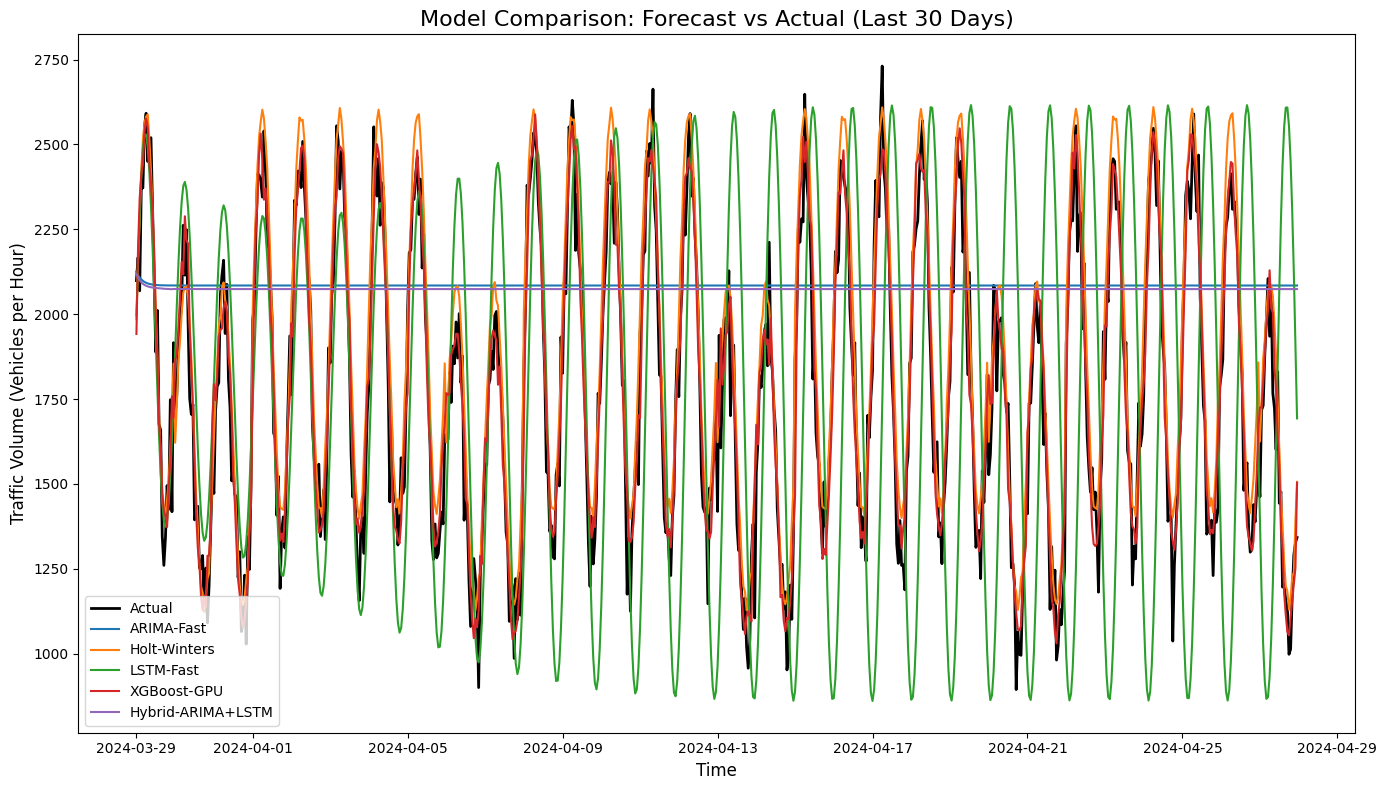

In [ ]:

import matplotlib.pyplot as plt


plt.figure(figsize=(14, 8))
plt.plot(test['traffic_volume'], label='Actual', color='black', linewidth=2)


for name, pred in predictions.items():
    plt.plot(pred, label=name)


plt.title('Model Comparison: Forecast vs Actual (Last 30 Days)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Traffic Volume (Vehicles per Hour)', fontsize=12)
plt.legend()
plt.tight_layout()

plt.show()
